# Explainability for PyTorch Models

We use 

```
@misc{jacobgilpytorchcam,
  title={PyTorch library for CAM methods},
  author={Jacob Gildenblat and contributors},
  year={2021},
  publisher={GitHub},
  howpublished={\url{https://github.com/jacobgil/pytorch-grad-cam}},
}
```

In [1]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [89]:
from scr.pytorch_model_defs import WaterPlasticModel

In [235]:
model = torch.load('pytorch_models/100_epochs_default.pth', weights_only=False)

In [4]:
# Load the data
from scr.pytorch_data_loaders import load_data_from_directory, ImageDataset

In [5]:
# # Paths to your data directories
# train_dir = "data/classification_dataset/train"
# validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# # Load the data
# train_images, train_labels = load_data_from_directory(train_dir)
# val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# train_dataset = ImageDataset(train_images, train_labels, transform=None)
# val_dataset = ImageDataset(val_images, val_labels, transform=None)
test_dataset = ImageDataset(test_images, test_labels, transform=None)



In [6]:
test_dataset

In [7]:
BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Typically no shuffle for test
    num_workers=2,
    pin_memory=True
)

# GradCAM

In [8]:
model

WaterPlasticModel(
  (conv1): Conv2d(12, 16, kernel_size=(12, 12), stride=(1, 1), padding=(6, 6))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(12, 12), stride=(1, 1), padding=(6, 6))
  (conv3): Conv2d(32, 64, kernel_size=(12, 12), stride=(1, 1), padding=(6, 6))
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
)

In [9]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt


In [223]:
for images, labels in test_loader:
    input_tensor = images
    labels = labels
    break

In [224]:
labels

tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1])

In [27]:
input_tensor.shape

torch.Size([32, 12, 32, 32])

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

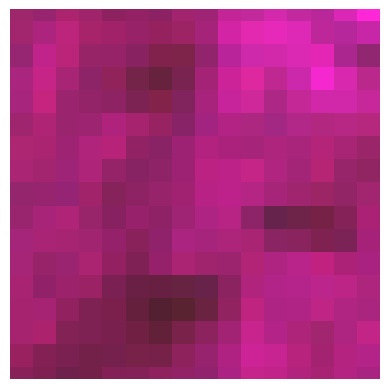

In [225]:
rgb_image = input_tensor[0, :][[3,2,1], :, :]
rgb_image = rgb_image.permute(1,2,0).numpy()
plt.imshow((rgb_image / np.max(rgb_image) * 255).astype(np.uint8))
plt.axis('off')
# plt.imshow((rgb_image / np.max(rgb_image) * 255).astype(np.uint8))

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

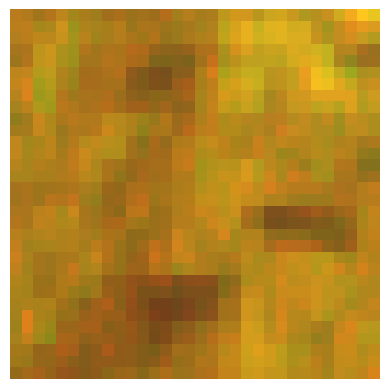

In [226]:
nir_image = input_tensor[0, :][[8,3,2], :, :]
nir_image = nir_image.permute(1,2,0).numpy()
plt.imshow((nir_image / np.max(nir_image) * 255).astype(np.uint8))
plt.axis('off')

In [236]:
target_layers = [model.conv3]
# target_layers = [model.conv2]
# target_layers = [model.conv1]

cam = GradCAM(model=model, target_layers=target_layers)

In [234]:
print(f"True Label: {labels[0]}")

True Label: 0


In [237]:
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]

In [238]:
water_grayscale_cam = cam(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam = cam(input_tensor=input_tensor, targets=plastic_target)

In [239]:
# In this example grayscale_cam has only one image in the batch:
water_visualization = show_cam_on_image(rgb_image, water_grayscale_cam[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization = show_cam_on_image(rgb_image, plastic_grayscale_cam[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

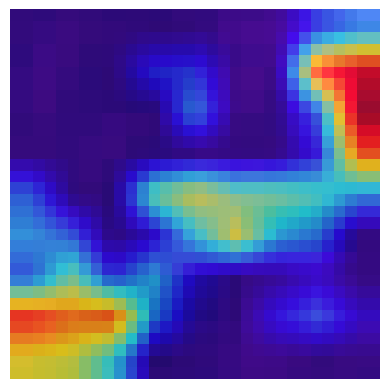

In [240]:
plt.imshow(water_visualization)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

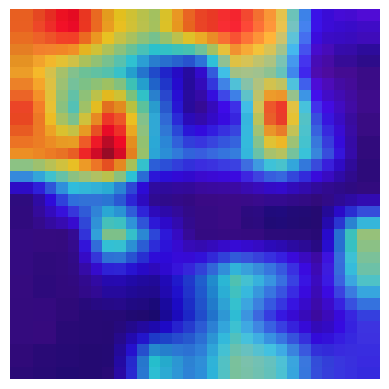

In [233]:
plt.imshow(plastic_visualization)
plt.axis('off')

In [105]:
import torch.nn.init as init

# Randomize Layers from top to bottom

## FC2

In [241]:
with torch.no_grad():
    init.kaiming_normal_(model.fc2.weight, nonlinearity='relu')
    if model.fc2.bias is not None:
        init.constant_(model.fc2.bias, 0)

In [242]:
cam_fc2 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_fc2 = cam_fc2(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_fc2 = cam_fc2(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_fc2 = show_cam_on_image(rgb_image, water_grayscale_cam_fc2[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_fc2 = show_cam_on_image(rgb_image, plastic_grayscale_cam_fc2[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

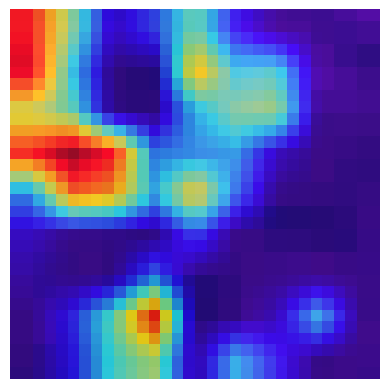

In [243]:
plt.imshow(water_visualization_fc2)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

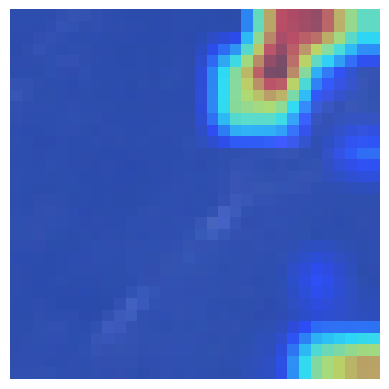

In [156]:
plt.imshow(plastic_visualization_fc2)
plt.axis('off')

## FC1?

In [244]:
with torch.no_grad():
    init.kaiming_normal_(model.fc1.weight, nonlinearity='relu')
    if model.fc1.bias is not None:
        init.constant_(model.fc1.bias, 0)


In [245]:
cam_fc1 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_fc1 = cam_fc1(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_fc1 = cam_fc1(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_fc1 = show_cam_on_image(rgb_image, water_grayscale_cam_fc1[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_fc1 = show_cam_on_image(rgb_image, plastic_grayscale_cam_fc1[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

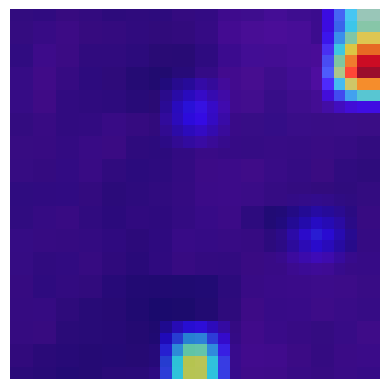

In [246]:
plt.imshow(water_visualization_fc1)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

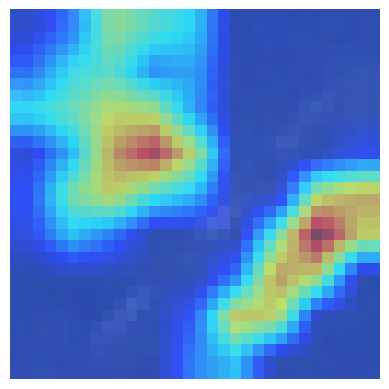

In [159]:
plt.imshow(plastic_visualization_fc1)
plt.axis('off')

## Randomize Conv3

In [247]:
# Assuming 'model' is your trained model and 'conv3' is the layer to reinitialize
with torch.no_grad():
    init.kaiming_normal_(model.conv3.weight, nonlinearity='relu')
    if model.conv3.bias is not None:
        init.constant_(model.conv3.bias, 0)



In [248]:
cam_conv3 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_conv3 = cam_conv3(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_conv3 = cam_conv3(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_conv3 = show_cam_on_image(rgb_image, water_grayscale_cam_conv3[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_conv3 = show_cam_on_image(rgb_image, plastic_grayscale_cam_conv3[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

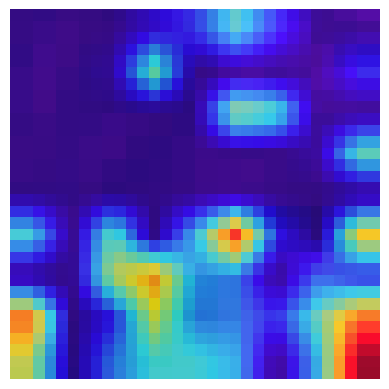

In [249]:
plt.imshow(water_visualization_conv3)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

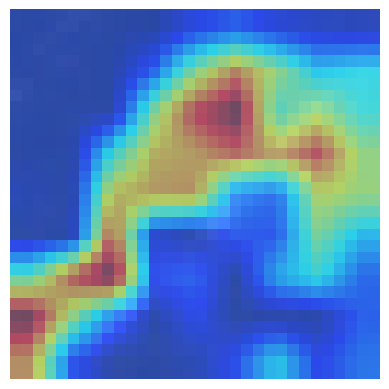

In [163]:
plt.imshow(plastic_visualization_conv3)
plt.axis('off')

## Randomize Conv2

In [250]:
with torch.no_grad():
    init.kaiming_normal_(model.conv2.weight, nonlinearity='relu')
    if model.conv2.bias is not None:
        init.constant_(model.conv2.bias, 0)


In [251]:
cam_conv2 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_conv2 = cam_conv2(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_conv2 = cam_conv2(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_conv2 = show_cam_on_image(rgb_image, water_grayscale_cam_conv2[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_conv2 = show_cam_on_image(rgb_image, plastic_grayscale_cam_conv2[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

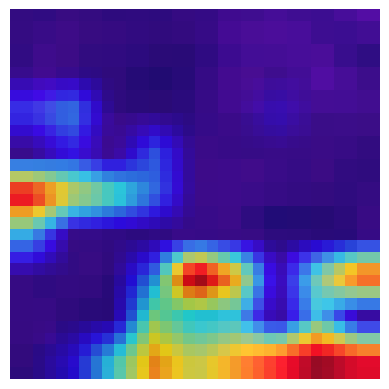

In [252]:
plt.imshow(water_visualization_conv2)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

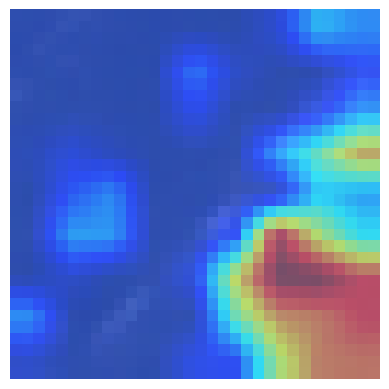

In [167]:
plt.imshow(plastic_visualization_conv2)
plt.axis('off')

## Randomize conv1

In [253]:
with torch.no_grad():
    init.kaiming_normal_(model.conv1.weight, nonlinearity='relu')
    if model.conv1.bias is not None:
        init.constant_(model.conv1.bias, 0)


In [254]:
cam_conv1 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_conv1 = cam_conv1(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_conv1 = cam_conv1(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_conv1 = show_cam_on_image(rgb_image, water_grayscale_cam_conv1[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_conv1 = show_cam_on_image(rgb_image, plastic_grayscale_cam_conv1[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

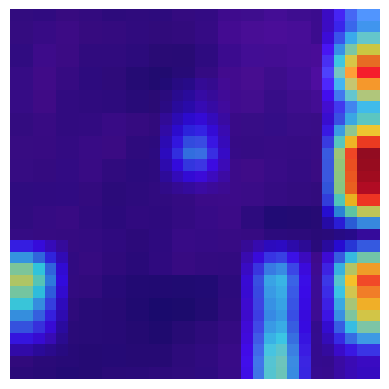

In [170]:
plt.imshow(water_visualization_conv1)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

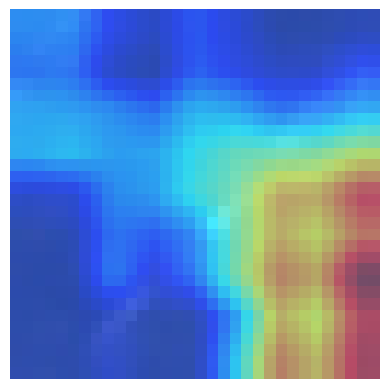

In [171]:
plt.imshow(plastic_visualization_conv1)
plt.axis('off')

# TODO: Metrics

In [135]:
from scr.similarity_metrics import spearman_rank_correlation_abs, spearman_rank_correlation_noabs, structural_similarity_index, pearson_correlation_hog